In [120]:
import numpy as np_ # Original numpy 
import scipy as sp

import random

# Plot
from IPython.display import display, Latex
import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator

# PennyLane
import pennylane as qml
from pennylane import numpy as np

# qnode device
dev = qml.device('default.mixed', wires = 1)

# Hamiltonian setup 
coeffs = [-0.5]
obs = [qml.PauliZ(0)]

hamiltonian = qml.Hamiltonian(coeffs, obs)  # Define Hamiltonian

In [121]:
# Global paras 
Tau_global = 5e-2   # Dephase tau
Paras_global, Phi_global  = np.zeros(2), 0

def Dephase_factor(tau):
    """ Take tau and return gamma based on the following relation."""

    Calculate_Gamma = 1 - np.exp(-2 * tau)
    
    return Calculate_Gamma    # Return gamma

In [122]:
Dephase_factor(2)

0.9816843611112658

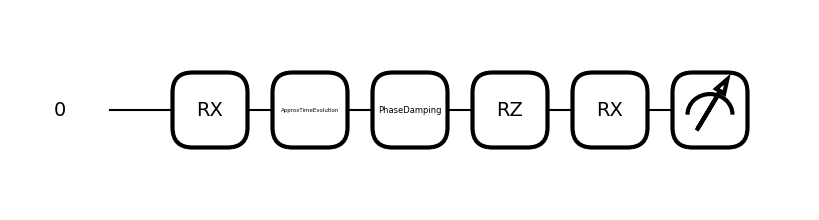

In [123]:
@qml.qnode(dev)
def circuit(phi):
    global Tau_global, Paras_global
    
    # Set dephase factor 
    gamma_dephase_in = Dephase_factor(Tau_global)  

    theta_x, phi_z = np.pi/2, np.pi/4

    qml.RX(np.pi/2, wires = 0)
    # qml.Hadamard(wires=0)

    qml.ApproxTimeEvolution(hamiltonian, phi, 1)
    qml.PhaseDamping(gamma_dephase_in, wires = 0)

    qml.RZ(phi_z, wires = 0)  # phi_z
    
    qml.RX(theta_x, wires = 0)  # theta_x
    
    return qml.density_matrix(wires = 0)

fig, ax = qml.draw_mpl(circuit)(1)

In [124]:
def Cost_function(paras):
    """ Calculate Classical-Fisher-Information for qnode(=Post_selection_Dephase).
    
    Args:
        paras (Numpy array): [theta_init, tau_1, tau_2, tau_d1, tau_d2, tau_d3]

    Returns:
        _type_: CFI with minus(-) sign.
    """
    
    global Paras_global, Phi_global
    Paras_global, phi = paras, np.array([Phi_global])
          
    CFI = qml.qinfo.classical_fisher(circuit)(phi[0])
    
    return -CFI

In [125]:
# == BFGS -> Return Data_set:[phi, CFI, 6-Paras] ==
def BFGS(Sweep_Data, paras, gamma_ps_select, Iterations):
    """ Perform maximum optimization using the L-BFGS-B algorithm.
    
    Args:
        Sweep_Data (numpy_array): Range of data sweeps.
        paras (numpy_array): Array of 3 parameters for the qnode.
        gamma_ps_select (int): The Gamma value for post-selection.
        Iterations (int): Number of iterations for the optimization.

    Returns:
        Numpy array: 3-Dimension Data array
    """
    
    # Create Data array
    PHI = np_.arange(Sweep_Data[0], Sweep_Data[1], Sweep_Data[2]).reshape(-1, 1)
    Data = np_.zeros((Iterations + 1, len(PHI), len(paras) + 2)) 
    
    Data[:, :, 0] = PHI.squeeze() # Append PHI in to 0th col
    
    # INDEX CONSTANT
    CFI_INDEX, PARAS_INDEX, BEFORE_OPT_LAYER_INDEX = 1, 2, 0
    
    # Set global variables
    global Gamma_ps, Phi_global, Paras_global
    Gamma_ps = gamma_ps_select 
    
    # Declare Paras temp 
    Paras_Temporary = 0
    
    # Before optimization; CFI data
    for Phi_Index in range(len(PHI)):
        Data[BEFORE_OPT_LAYER_INDEX][Phi_Index][CFI_INDEX] = -Cost_function(paras)
        
        for Paras_Index_Array in range(len(paras)):
            Data[BEFORE_OPT_LAYER_INDEX][Phi_Index][PARAS_INDEX + Paras_Index_Array] = paras[Paras_Index_Array]
        
        
    # Optimize begin
    for Layer_Index in range(1, Iterations + 1):
        for Phi_Index in range(len(PHI)):
            # Load previous paras
            Paras_Temporary = paras if Layer_Index == 1 else Data[Layer_Index][Phi_Index][PARAS_INDEX:]
            
            # Set Phi(Currently sweeping)
            Phi_global = Data[Layer_Index][Phi_Index][0]
            
            # # Constraints(gamma = 0.99..) 
            # tau_upper = 18
            # # Constraints = [(-float('inf'), float('inf'))] * 2 
            # Constraints = [(0 - 1e-1, 1*np.pi + 1e-1)] * 2 
            
            # # Push paras to global var
            # Paras_global = Paras_Temporary
            # Result_BFGS = sp.optimize.minimize(
            #     Cost_function, 
            #     Paras_Temporary, 
            #     method = 'L-BFGS-B', 
            #     bounds = Constraints,
            #     options={'maxiter': 16000 * 10}
            #     )
            
            # Set constraints
            N = int(PHI[Phi_Index] / np.pi) + 1            
            Select_1 = [(0, np.pi)] * 2
            # Select_2 = [(-float('inf'), float('inf'))] * 2 
            Select_2 = [(-np.pi/2, (3*np.pi)/2)] * 2 
                       
            Constraints = (
                Select_1 
                if (PHI[Phi_Index] < 1.4 * N) or (PHI[Phi_Index] > 1.7 * N) 
                else Select_2
                )
            
            # Push paras to global var
            Paras_global = Paras_Temporary
            Result_BFGS = sp.optimize.minimize(
                Cost_function, 
                Paras_Temporary, 
                method = 'L-BFGS-B', 
                bounds = Constraints,
                # options={'maxiter': 16000*10}
                )
            
            Data[Layer_Index][Phi_Index][CFI_INDEX] = -Result_BFGS.fun
            
            # Store data in array
            for Paras_Index_Array in range(len(Paras_Temporary)):
                Data[Layer_Index][Phi_Index][PARAS_INDEX + Paras_Index_Array] = Result_BFGS.x[Paras_Index_Array]
            
    return Data

In [126]:
tau_plot = 0, 5e-2, 1e-1, 5e-1, 1, 2, 3, 4

range_sweep = np_.array([0, np.pi * 4 , 1e-2])
PHI = np_.arange(range_sweep[0], range_sweep[1], range_sweep[2]).reshape(-1, 1)
Data = np_.zeros((len(PHI), len(tau_plot) + 1))
Data[:, 0] = PHI.squeeze()

for tau_idx, tau in enumerate(tau_plot):
    Tau_global = tau
    for phi_idx, phi_current in enumerate(PHI):
        phi_in = np.array([phi_current])
        Data[phi_idx][tau_idx+1] = qml.qinfo.classical_fisher(circuit)(phi_in[0])

In [127]:
# range_sweep = np_.array([0, np.pi * 4 , 1e-2])
# PHI = np_.arange(range_sweep[0], range_sweep[1], range_sweep[2]).reshape(-1, 1)
# Data = np_.zeros((len(PHI), len(tau_plot) + 1))
# Data[:, 0] = PHI.squeeze()

In [128]:
Data[:,2]

# PHI

array([0.82621287, 0.82329311, 0.8202748 , ..., 0.83346629, 0.8307894 ,
       0.82802321])

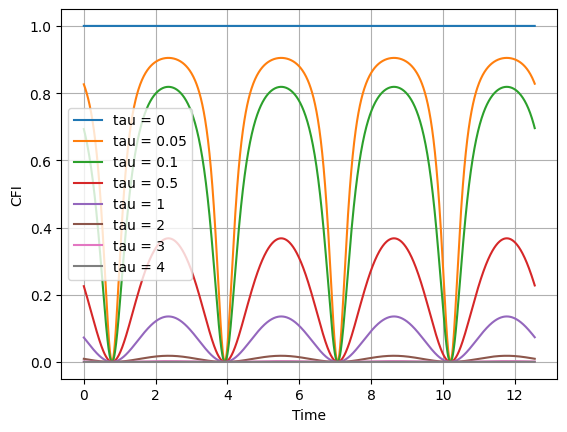

In [131]:
# DUMMY = np.zeros(len(Data[:, 0]))

# plt.plot(Data[:, 0], DUMMY, label = 'DUMMY')
for tau_idx in range(len(tau_plot)):
    plt.plot(Data[:, 0], Data[:, 1 + tau_idx], label = f'tau = {tau_plot[tau_idx]}')
    

plt.xlabel('Time')
plt.ylabel('CFI')
plt.grid()
plt.legend()

In [130]:
PHI = np.arange(range_sweep[0], range_sweep[1], range_sweep[2]).reshape(-1, 1)


for phi_idx, phi_current in enumerate(PHI):
    print(type(phi_current))


<class 'pennylane.numpy.tensor.tensor'>
<class 'pennylane.numpy.tensor.tensor'>
<class 'pennylane.numpy.tensor.tensor'>
<class 'pennylane.numpy.tensor.tensor'>
<class 'pennylane.numpy.tensor.tensor'>
<class 'pennylane.numpy.tensor.tensor'>
<class 'pennylane.numpy.tensor.tensor'>
<class 'pennylane.numpy.tensor.tensor'>
<class 'pennylane.numpy.tensor.tensor'>
<class 'pennylane.numpy.tensor.tensor'>
<class 'pennylane.numpy.tensor.tensor'>
<class 'pennylane.numpy.tensor.tensor'>
<class 'pennylane.numpy.tensor.tensor'>
<class 'pennylane.numpy.tensor.tensor'>
<class 'pennylane.numpy.tensor.tensor'>
<class 'pennylane.numpy.tensor.tensor'>
<class 'pennylane.numpy.tensor.tensor'>
<class 'pennylane.numpy.tensor.tensor'>
<class 'pennylane.numpy.tensor.tensor'>
<class 'pennylane.numpy.tensor.tensor'>
<class 'pennylane.numpy.tensor.tensor'>
<class 'pennylane.numpy.tensor.tensor'>
<class 'pennylane.numpy.tensor.tensor'>
<class 'pennylane.numpy.tensor.tensor'>
<class 'pennylane.numpy.tensor.tensor'>
